In [ ]:
import torch
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 43 kB 751 kB/s 
     |████████████████████████████████| 370 kB 4.3 MB/s 
     |████████████████████████████████| 482 kB 37.2 MB/s 
     |████████████████████████████████| 41 kB 460 kB/s 


In [ ]:
# transformation function
import torch_geometric.transforms as T

## Visualization

In [ ]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

# Dataset
* len(dataset)- number of graphs in the dataset
    * data = dataset[0]- get the fist graph object
* dataset.num_features- how each node is represented (a feature vector)
* dataset.num_classes- number of classes in the dataset

In [ ]:
# KarateClub
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')  # #graphs in the dataset
print(f'Number of features: {dataset.num_features}')  #  each node in is a 34-dimensional feature vector
print(f'Number of classes: {dataset.num_classes}')  # the graph holds exactly 4 classes

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


## Data object
* Each graph in PyTorch Geometric is represented by a single Data object, which holds all the information to describe its graph representation

* Data object holds 4 attributes:
    1. `edge_index`- holds the information about the graph connectivity
        * a tuple of source and destination node indices for each edge.
        * **COO format** (coordinate format)- commonly used for representing sparse matrices
    1. `x`- node features (a feature vector).
    1.  `y`- node labels
    1. `train_mask`- describes for which nodes we already know their community assigments. 

### Properties
* data.num_nodes- total nodes in a graph
* data.num_edges- total edges in a graph
* data.has_isolated_nodes()- check if the graph has isolated nodes (boolean)
* data.has_self_loops()- check if the graph has self loops (boolean)
* data.is_undirected()- check if the graph is undirected
* data.train_mask- train mask (boolean) for train-test split
* data.edge_index- each column represent an edge (2, \|E\|)
    * data.edge_index.T shape: (\|E\|, 2)

In [ ]:

data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
data.edge_index.shape

torch.Size([2, 156])

In [ ]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

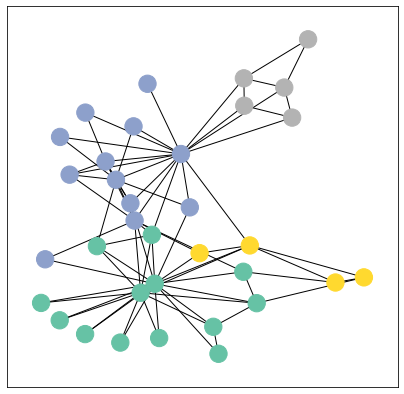

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

# GNN
The goal of a GNN is to take an input graph $G = (\mathcal{V}, \mathcal{E})$ where each node $v_i \in \mathcal{V}$ has an input feature vector $X_i^{(0)}$. What we want to learn is a function $f \to \mathcal{V} \times \mathcal{R}^d$, a function that takes in a node and its feature vector, as well as the graph structure, and outputs an _embedding_, a vector that represents that node in a way that's useful to our downstream task. Once we've mapped nodes and their initial features to their learned embeddings, we can use those embeddings to do a variety of different tasks including node-level, edge-level, or graph-level regression/classification.

## Training
* While we compute node embeddings for all of our nodes, we only make use of the training nodes for computing the loss.
    * filter the output of the classifier out and ground-truth labels data.y to only contain the nodes in the train_mask.

```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.classifier = Linear(2, dataset.num_classes)

        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        for l in range(num_layers-1):
          self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):

        for l in range(num_layers):
          x = self.convs[l](x, edge_index)
          x = x.tanh()
    
        #h = self.relu(h)
        h = torch.nn.functional.relu(h)
        h = torch.nn.functional.dropout(h, dropout=0.5, training=self.training)
        h = self.conv3(h, edge_index)
        embeddings = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)
        # output the embeddings for visualization (hidden representation with 2 dimensions)
        return out, embeddings

model = GCN()
print(model)

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)